In [2]:
from pathlib import Path
import math
from itertools import combinations_with_replacement, islice

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors
import matplotlib.cm
from tqdm.auto import tqdm

import numpy as np
import numpy

import torch
import torch.nn as nn

# MNIST tanh

In [4]:
BINS = 8
LAYERS = [(25, 6), (6, 6), (6, 6), (6, 5)]
ACTIVATION = nn.Tanh()
RUNS = 3
FREQUENCY = 20 # epochs per measurement
EPOCHS = 500
BATCH_SIZE = 50
print("Total Measurements: {}".format(EPOCHS / FREQUENCY))

top_str = ""
for i, l in enumerate(LAYERS):
    if i == len(LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

Total Measurements: 25.0


In [5]:
exp_dir = Path('/home/eric/Code/deep-ei-private/runs/absolute-final/mnist25-6-6-6-5tanh')
run_folders = [exp_dir / f"run{i}-frames" for i in range(1, RUNS+1)]
# run_folders = [here / "run1-frames"]
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/absolute-final/mnist25-6-6-6-5tanh/run1-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/absolute-final/mnist25-6-6-6-5tanh/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/absolute-final/mnist25-6-6-6-5tanh/run3-frames')]


In [6]:
all(d.exists() for d in run_folders)

True

In [7]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
        'model'
    ]
    for i in range(len(LAYERS)):
        start_i = end_i = i
#     for (start_i, end_i) in combinations_with_replacement(range(len(LAYERS)), 2):
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [8]:
runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for run_datapoints in runs_datapoints:
    run_datapoints.sort(key=lambda f: f['batches'])

AttributeError: 'PosixPath' object has no attribute 'tell'

In [7]:
ltl = {
    0: 'X',
    1: 'T1',
    2: 'T2',
    3: 'T3',
    4: 'Y'
}

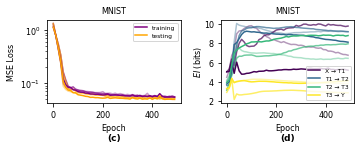

In [39]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.text(0.5, -0.45, "(c)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)
ax.set_title("MNIST", fontsize=8)


ax = plt.subplot(1, 2, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI$ (bits)',fontsize=8)
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.yaxis.labelpad = 0
ax.set_title("MNIST", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(d)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/mnist-ei-whole-timeseries.pdf', dpi=100)


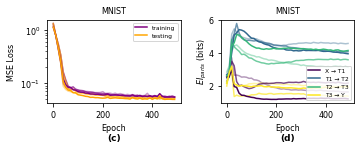

In [40]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.set_title("MNIST", fontsize=8)
ax.text(0.5, -0.45, "(c)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI_{parts}$ (bits)',fontsize=8)
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.yaxis.labelpad = 0
ax.set_title("MNIST", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(d)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/mnist-ei-parts-timeseries.pdf', dpi=100)


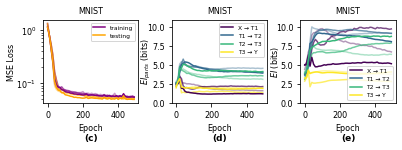

In [42]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 3, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.yaxis.labelpad = 0
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.set_title("MNIST", fontsize=8)
ax.text(0.5, -0.45, "(c)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 3, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI_{parts}$ (bits)',fontsize=8)
ax.set_ylim(0, 11)
ax.yaxis.labelpad = -5.5
ax.legend(loc='upper right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.set_title("MNIST", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(d)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

ax = plt.subplot(1, 3, 3)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI$ (bits)',fontsize=8)
ax.set_ylim(0, 11)
ax.yaxis.labelpad = -5.5
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.set_title("MNIST", fontsize=8)

plt.subplots_adjust(wspace=0.35, bottom=0.3, left=0.1, right=0.99)

ax.text(0.5, -0.45, "(e)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/mnist-ei-parts-and-whole-timeseries.pdf', dpi=100)


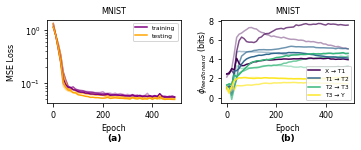

In [10]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.set_title("MNIST", fontsize=8)
ax.text(0.5, -0.45, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_parts_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        ei_whole_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_whole_layer - ei_parts_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$\phi_{feedforward}$ (bits)',fontsize=8)
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.yaxis.labelpad = 0
ax.set_title("MNIST", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(b)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/mnist-ii-timeseries.pdf', dpi=100)


# IRIS

In [11]:
########### PARAMS ############
BINS = 256
LAYERS = [(4, 5), (5, 5), (5, 3)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 40 # epochs per measurement
EPOCHS = 4000
# BATCH_SIZE = 10 this is fixed

top_str = "sigmoid"
for i, l in enumerate(LAYERS):
    if i == len(LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

In [12]:
here = Path('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer')
run_folders = list(here.glob("run*-frames"))
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run3-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run1-frames')]


In [13]:
all(d.exists() for d in run_folders)

True

In [14]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
    ]
    for (start_i, end_i) in combinations_with_replacement(range(len(LAYERS)), 2):
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [15]:
runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for run_datapoints in runs_datapoints:
    run_datapoints.sort(key=lambda f: f['batches'])

In [16]:
ltl = {
    0: 'X',
    1: 'T1',
    2: 'T2',
    3: 'Y'
}

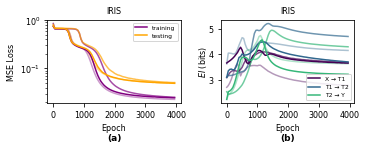

In [51]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.set_title("IRIS", fontsize=8)
ax.text(0.5, -0.45, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI$ (bits)',fontsize=8)
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.yaxis.labelpad = 0
ax.set_title("IRIS", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(b)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/iris-ei-whole-timeseries.pdf', dpi=100)


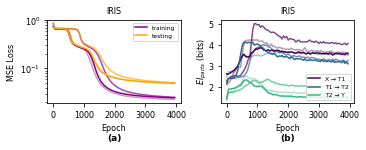

In [53]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.text(0.5, -0.45, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)
ax.set_title("IRIS", fontsize=8)


ax = plt.subplot(1, 2, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI_{parts}$ (bits)',fontsize=8)
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.yaxis.labelpad = 0
ax.set_title("IRIS", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(b)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/iris-ei-parts-timeseries.pdf', dpi=100)


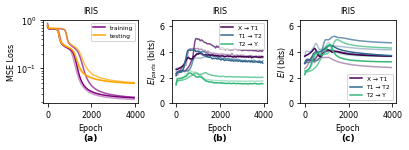

In [54]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 3, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"IRIS: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.yaxis.labelpad = 0
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.set_title("IRIS", fontsize=8)
ax.text(0.5, -0.45, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 3, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI_{parts}$ (bits)',fontsize=8)
ax.set_ylim(0, 6.5)
ax.yaxis.labelpad = 0
ax.legend(loc='upper right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.set_title("IRIS", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(b)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

ax = plt.subplot(1, 3, 3)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$EI$ (bits)',fontsize=8)
ax.set_ylim(0, 6.5)
ax.yaxis.labelpad = 0
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.set_title("IRIS", fontsize=8)

plt.subplots_adjust(wspace=0.35, bottom=0.3, left=0.1, right=0.99)

ax.text(0.5, -0.45, "(c)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/iris-ei-parts-and-whole-timeseries.pdf', dpi=100)


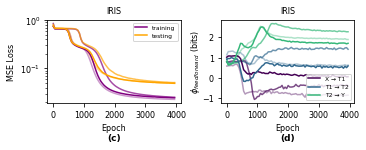

In [19]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 2, 1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.tick_params(axis='both',which='major',labelsize=8)
plt.legend(loc='upper right', prop={'size':6})
plt.yscale('log')
ax.set_title("IRIS", fontsize=8)
ax.text(0.5, -0.45, "(c)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax = plt.subplot(1, 2, 2)

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epochs'] for f in run]
    for l in range(len(LAYERS)):
        ei_parts_layer = np.array([f[f"pairwise-ei:{l}-{l}"] for f in run])
        ei_whole_layer = np.array([f[f"vector-ei:{l}-{l}"] for f in run])
        line, = ax.plot(epochs, ei_whole_layer - ei_parts_layer, c=matplotlib.cm.viridis(l/3), alpha=0.4 + 0.3*i)
        if i == 2:
            line.set_label(f"{ltl[l]} → {ltl[l+1]}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel('Epoch', fontsize = 8)
ax.set_ylabel('$\phi_{feedforward}$ (bits)',fontsize=8)
ax.legend(loc='lower right', prop={'size': 6})
ax.tick_params(axis='both',which='major',labelsize=8)
ax.yaxis.labelpad = 0
ax.set_title("IRIS", fontsize=8)

plt.subplots_adjust(wspace=0.3, bottom=0.3)

ax.text(0.5, -0.45, "(d)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/iris-ii-timeseries.pdf', dpi=100)
